In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('../')
from utilities import *

sys.path.append('../lib')
from vae_2d import *
from Koopman_2d import *
# from fno_2d import *
from rnn_base import *

from timeit import default_timer
import scipy.io
import os
import matplotlib.pyplot as plt
import tqdm as tqdm

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# define as a picture with one channel
in_dim = 1 
out_dim = 1 

steps = 1
steps_back = 1
backward = True

batch_size = 16
epochs = 50
learning_rate = 0.0001
scheduler_step = 10
scheduler_gamma = 0.5
gamma_2 = 0.1

loss_k = 0 # H0 Sobolev loss = L2 loss
loss_group = True

print(epochs, learning_rate, scheduler_step, scheduler_gamma)
sub = 4 # spatial subsample
S = 256 # size of image, also the domain size
S = S // sub

T_in = 2 # skip first 100 seconds of each trajectory to let trajectory reach attractor
T_pred = 1000 # prediction steps
T_out = T_in + T_pred
step = 1 # Seconds to learn solution operator


50 0.0001 10 0.5


In [3]:
# Process and prepare cosmology data for visualization and model evaluation
processing = True  # Flag to control whether to process data from scratch or load pre-processed data
save = False       # Flag to control whether to save processed data to disk
ntest = 2          # Number of test trajectories to use

if processing == True:
    t1 = default_timer()
    # Load the cosmology simulation data
    data = np.load('../data/kf_2d_re1000_256_120seed.npy')
    data = data.reshape(1, *data.shape)  # Reshape to add a dimension at the front
    print(data.shape)  # Should now be (1, 595, 192, 192)
    
    # Convert to torch tensor and downsample spatially by factor of 'sub'
    data = torch.tensor(data, dtype=torch.float)[..., ::sub, ::sub]
    print("downsampled data.shape: ", data.shape)
    # Sample a subset of episodes for testing
    episode_samples = 100
    test_samples = int(episode_samples*0.1)  # Use 10% of samples for testing
    # This line randomly selects a subset of test data:
    # 1. data[-ntest:] - Takes the last 'ntest' trajectories from the dataset
    # 2. torch.randperm() - Creates a random permutation of indices
    # 3. [:test_samples] - Selects only the first 'test_samples' indices
    # 4. data[...,...] - Uses these indices to sample from the data
    print(torch.randperm(data[-ntest:].size(0))[:test_samples])
    data_sampled_test = data[torch.randperm(data[-ntest:].size(0))[:test_samples],...]
    print(data_sampled_test.shape)
    print(data_sampled_test[:,T_in-1:T_out-1].shape)
    # Extract input-output pairs for testing
    # test_input: inputs (current states)
    # test_gt: targets (next states)
    test_input = data_sampled_test[:, :-1].reshape(-1, S, S)
    test_gt = data_sampled_test[:,1:].reshape(-1, S, S)
    
    # Save processed data if requested
    if save == True:
        # Save test data to a MAT file for later use
        scipy.io.savemat('./data/2D_cosmology_test.mat', mdict={'a': test_input.numpy(), 'u': test_gt.numpy()})

    t2 = default_timer()

    # Verify that the spatial dimensions match expected size
    assert (S == test_gt.shape[2])

# Commented out code for processing training data
# if processing:
#     t1 = default_timer()
#     data = torch.tensor(data, dtype=torch.float)[..., ::sub, ::sub]
#     episode_samples = 300
#     test_samples = int(episode_samples*0.1)
#     data_sampled_train = data[torch.randperm(data[:ntrain].size(0))[:episode_samples],...]
#     data_sampled_test = data[torch.randperm(data[-ntest:].size(0))[:test_samples],...]

#     train_a = data_sampled_train[:,T_in-1:T_out-1].reshape(-1, S, S)
#     train_u = data_sampled_train[:,T_in:T_out].reshape(-1, S, S)
#     test_input = data_sampled_test[:,T_in-1:T_out-1].reshape(-1, S, S)
#     test_gt = data_sampled_test[:,T_in:T_out].reshape(-1, S, S)

#     if save:
#         # save train and test data to a mat file to data folder
#         scipy.io.savemat('./data/2D_NS_Re500_train.mat', mdict={'a': train_a.numpy(), 'u': train_u.numpy()})
#         scipy.io.savemat('./data/2D_NS_Re500_test.mat', mdict={'a': test_input.numpy(), 'u': test_gt.numpy()})

#     t2 = default_timer()

if processing == False:
    # If not processing from scratch, load pre-processed data from MAT files
    train_a = torch.tensor(scipy.io.loadmat('../data/2D_NS_Re500_train.mat')['a'], dtype=torch.float32)
    train_u = torch.tensor(scipy.io.loadmat('../data/2D_NS_Re500_train.mat')['u'], dtype=torch.float32)
    test_input = torch.tensor(scipy.io.loadmat('../data/2D_NS_Re500_test.mat')['a'], dtype=torch.float32)
    test_gt = torch.tensor(scipy.io.loadmat('../data/2D_NS_Re500_test.mat')['u'], dtype=torch.float32)

# Print shapes to verify data dimensions
print(test_input.shape)
print(test_gt.shape)

# Create a DataLoader for batch processing during evaluation
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_input, test_gt), batch_size=batch_size, shuffle=False)

(1, 120, 320, 256, 256)
downsampled data.shape:  torch.Size([1, 120, 320, 64, 64])
tensor([0])
torch.Size([1, 120, 320, 64, 64])
torch.Size([1, 119, 320, 64, 64])
torch.Size([38080, 64, 64])
torch.Size([38080, 64, 64])


Customize the model path before load

In [6]:
# Set up device for computation
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the transformer model for cosmology prediction
model_trans_24 = torch.load('../mainmodel/final_model_final_7_kf_with_qcbm&id.pt', map_location=device, weights_only=False)
model_trans_24.eval()
# Function to count model parameters
def count_parameters(model):
    """
    Count the total number of trainable parameters in a PyTorch model.
    
    Args:
        model: PyTorch model
        
    Returns:
        total_params: Total number of trainable parameters
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params:,}')
    return total_params

# Display the model architecture
print(model_trans_24)

# Count and display the number of parameters
count_parameters(model_trans_24)


KoopmanAE_2d_trans(
  (patch_embed): OverlapPatchEmbed(
    (proj): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (encoder_level1): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm(
        (body): WithBias_LayerNorm()
      )
      (attn): Attention(
        (qkv): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (qkv_dwconv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (project_out): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (norm2): LayerNorm(
        (body): WithBias_LayerNorm()
      )
      (ffn): FeedForward(
        (project_in): Conv2d(16, 84, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (dwconv): Conv2d(84, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=84, bias=False)
        (project_out): Conv2d(42, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): TransformerBlock(
 

4534872

In [ ]:
# Initialize variables for prediction
id = 0  # Starting index for test data
test_initial = test_input[int(id*T_pred)]  # Get the initial condition from test data
s = S  # Grid size for spatial dimensions

def predictions(model, test_input_0, s, T, rnn=False, koopman=False):
    """
    Generate predictions using the specified model for T timesteps.
    
    Args:
        model: The trained neural network model
        test_input_0: Initial condition tensor
        s: Spatial dimension size
        T: Number of time steps to predict
        rnn: Flag for RNN-type models which require different input formatting
        koopman: Flag for Koopman-based models which use a specific forward mode
        
    Returns:
        pred: Tensor of shape (T, s, s) containing predictions for all timesteps
    """
    pred = torch.zeros(T, s, s)  # Initialize output tensor to store predictions
    out = test_input_0.reshape(1,s,s).to(device)  # Reshape initial condition and move to device
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for i in range(T):  # Iterate through each timestep
            # Apply the appropriate model forward pass based on model type
            if rnn:
                # RNN models expect input shape (batch, sequence, height, width)
                out = model(out.view(1,1,s,s))
            elif koopman:
                # Koopman models use a specific forward mode and return format
                out = model(out.view(1,s,s,1), mode='forward')[0][0]
            else:
                # Standard models with shape (batch, height, width, channels)
                out = model(out.view(1,s,s,1))[0]
            
            # Store the prediction for this timestep
            pred[i] = out.view(-1,s,s)
            
            # Note: For autoregressive prediction, each step's output becomes the next step's input
    
    return pred

# Generate predictions using the transformer model
generated_data = predictions(model_trans_24, test_initial, s, T_pred, koopman=True)
np.save('../data/kf_qprior_7.npy', generated_data)
print(generated_data.shape)

torch.Size([1000, 64, 64])


torch.Size([38080, 64, 64])


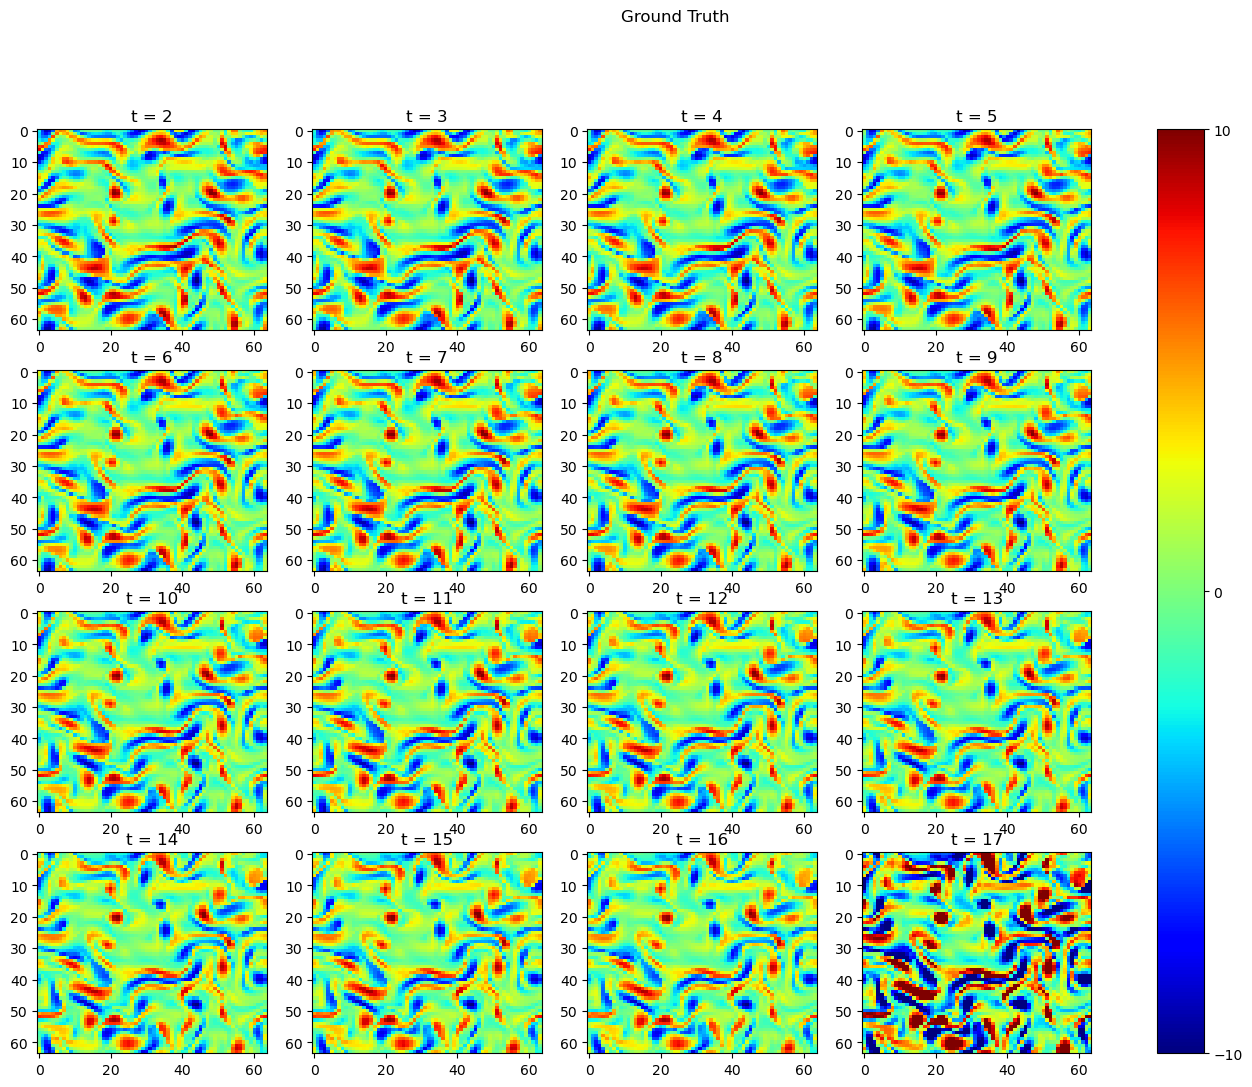

In [6]:
def preview_plot(data_tensor, n=3, T_id=0, title='Preview', vmin=-5, vmax=5):
    """
    Creates a grid of n×n subplots to visualize data from a tensor at different timesteps.
    
    This function generates a visualization grid where each subplot shows the data at a specific
    timestep. The grid is arranged in n rows and n columns, displaying a total of n² timesteps
    starting from T_id.
    
    Parameters:
    -----------
    data_tensor : torch.Tensor or numpy.ndarray
        The tensor containing data to visualize, with shape (timesteps, height, width)
    n : int, default=3
        Number of rows and columns in the grid (total subplots will be n²)
    T_id : int, default=0
        Starting timestep index for visualization
    title : str, default='Preview'
        Title for the overall figure
    vmin : float, default=-20
        Minimum value for color scaling
    vmax : float, default=20
        Maximum value for color scaling
        
    Returns:
    --------
    None. Displays the plot using plt.show()
    
    Notes:
    ------
    - Each subplot shows a 2D heatmap of data at a specific timestep
    - The function transposes each image with .T for proper orientation
    - A single colorbar is added for the entire figure
    - Each subplot is labeled with its corresponding timestep (t = index + 400)
    """
    # Create a figure with n×n subplots with a size proportional to n
    fig, ax = plt.subplots(n, n, figsize=(3*n+5, 3*n))
    images = []  # List to store the return values of imshow
    print(data_tensor.shape)
    # Iterate through each subplot position
    for i in range(n):
        for j in range(n):
            # Calculate the timestep index for this subplot
            index = i*n + j + T_id
            # Plot the data as a heatmap with jet colormap
            img_display = ax[i][j].imshow(data_tensor[index].T, cmap='jet', aspect='auto')
            images.append(img_display)  # Store the imshow object for later colorbar use
            # Set the title for this subplot showing the timestep
            ax[i][j].set_title('t = {}'.format(index + T_in))
    
    # Set the color limits for the last image (affects all images)
    images[-1].set_clim(vmin, vmax)

    # Add a single colorbar for all subplots
    color_bar = fig.colorbar(images[-1], ax=ax.ravel().tolist(), orientation='vertical')
    # Set specific tick marks on the colorbar at min, 0, and max values
    color_bar.set_ticks([vmin, 0, vmax])
    
    # Add an overall title to the figure
    plt.suptitle(title)
    # Display the figure
    plt.show()

preview_plot(test_gt[0:], n=4, T_id=0, title='Ground Truth',vmin=-10,vmax=10)

torch.Size([1000, 64, 64])


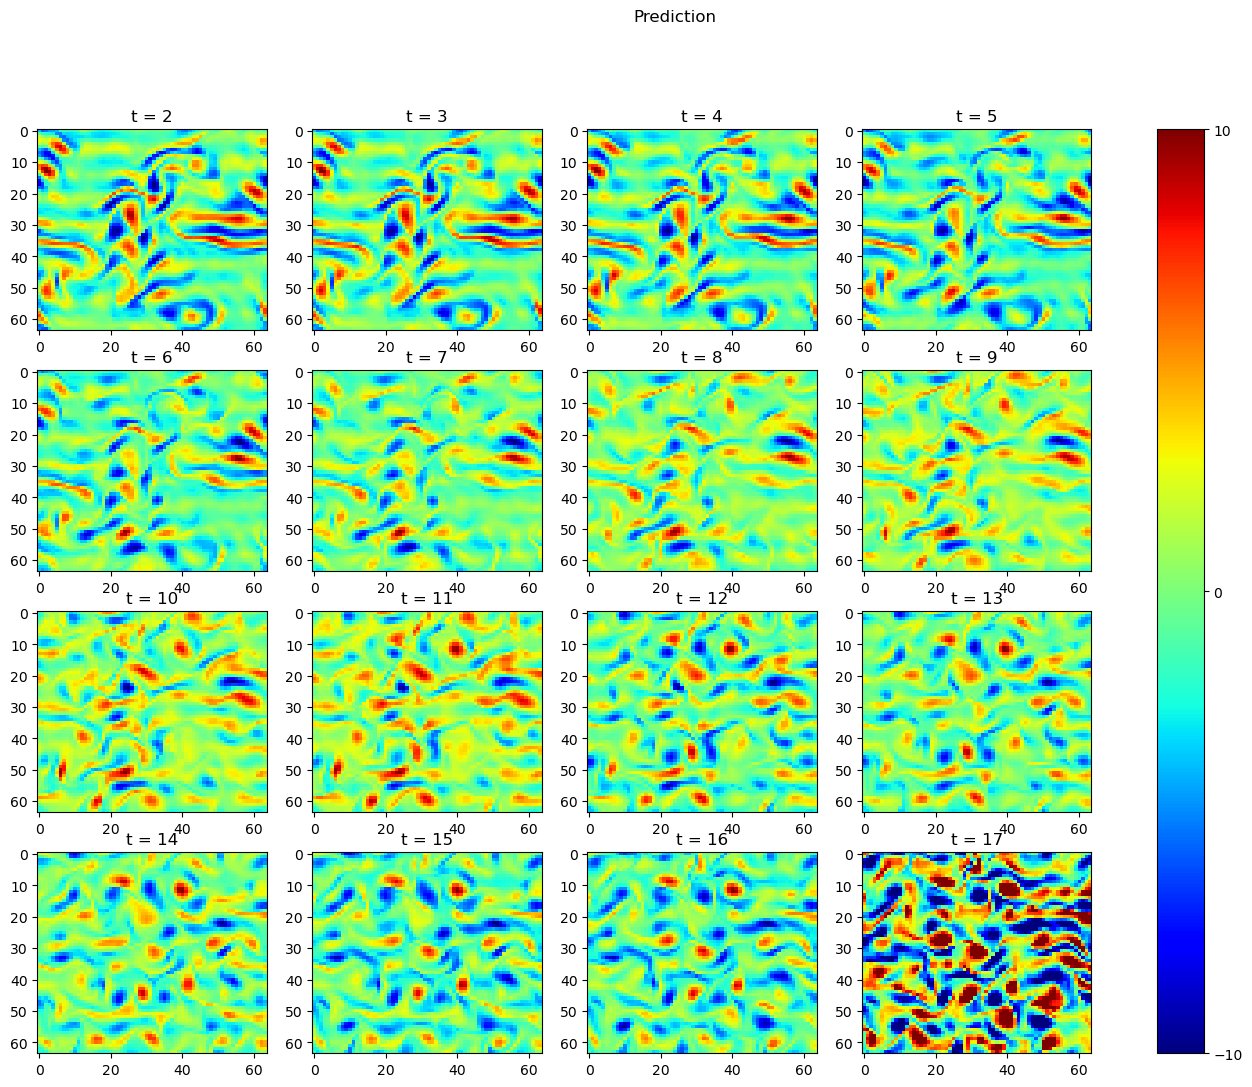

In [7]:

preview_plot(generated_data, n=4, T_id=0, title='Prediction',vmin=-10,vmax=10)

In [35]:
def save_as_movie(data_tensor, filename='animation.mp4', fps=20, title='Simulation', vmin=-10, vmax=10, dpi=100):
    """
    Creates and saves a movie from a tensor of time-evolving data.
    
    Parameters:
    -----------
    data_tensor : torch.Tensor or numpy.ndarray
        The tensor containing data to visualize, with shape (timesteps, height, width)
    filename : str, default='animation.mp4'
        Output filename for the movie (should end with .mp4)
    fps : int, default=10
        Frames per second for the output video
    title : str, default='Simulation'
        Title for the movie
    vmin : float, default=-20
        Minimum value for color scaling
    vmax : float, default=20
        Maximum value for color scaling
    dpi : int, default=100
        Resolution of the output video
        
    Returns:
    --------
    None. Saves the movie to the specified filename.
    """
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    
    # Print shape information for debugging
    print(f"Creating movie from data with shape: {data_tensor.shape}")
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create the initial plot
    img = ax.imshow(data_tensor[0].T, cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
    
    # Add a colorbar
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_ticks([vmin, 0, vmax])
    
    # Add a title with frame counter
    title_obj = plt.title(f'{title} - Frame: 0/{len(data_tensor)-1}')
    
    # Function to update the figure for each frame
    def update_frame(frame_num):
        # Update the image data
        img.set_array(data_tensor[frame_num].T)
        
        # Update the title with current frame number
        title_obj.set_text(f'{title} - Frame: {frame_num}/{len(data_tensor)-1}')
        
        return [img, title_obj]
    
    # Create the animation
    print(f"Generating animation with {len(data_tensor)} frames at {fps} fps...")
    anim = animation.FuncAnimation(
        fig, update_frame, frames=len(data_tensor), 
        interval=1000/fps, blit=True
    )
    
    # Save the animation
    print(f"Saving animation to {filename}...")
    try:
        # Try using FFmpeg writer first
        writer = animation.FFMpegWriter(fps=fps)
        anim.save(filename, writer=writer, dpi=dpi)
    except (FileNotFoundError, RuntimeError) as e:
        print(f"Error with FFmpeg: {e}")
        print("Trying PillowWriter instead...")
        try:
            # Fall back to PillowWriter (for GIF)
            if not filename.endswith('.gif'):
                filename = filename.rsplit('.', 1)[0] + '.gif'
                print(f"Changed output filename to {filename}")
            
            writer = animation.PillowWriter(fps=fps)
            anim.save(filename, writer=writer, dpi=dpi)
        except Exception as e2:
            print(f"Error with PillowWriter: {e2}")
            print("Could not save animation. Please install FFmpeg or use a different method.")
            # Display the animation in the notebook as a fallback
            from IPython.display import display
            print("Displaying animation in notebook instead...")
            plt.close(fig)  # Close the current figure
            return anim  # Return the animation object for display
    
    # Close the figure to free memory~
    plt.close(fig)
    
    print(f"Movie saved to {filename}")
    return None


In [36]:
save_as_movie(test_gt[:T_pred], filename='gt_KF.mp4', fps=20, title='Simulation', vmin=-10, vmax=10, dpi=100)
save_as_movie(generated_data, filename='prediction_kf_15.mp4', fps=20, title='Prediction', vmin=-10, vmax=10, dpi=100)

Creating movie from data with shape: torch.Size([1000, 64, 64])
Generating animation with 1000 frames at 20 fps...
Saving animation to gt_ISO.mp4...
Error with FFmpeg: [Errno 2] No such file or directory: 'ffmpeg'
Trying PillowWriter instead...
Changed output filename to gt_ISO.gif


Movie saved to gt_ISO.gif
Creating movie from data with shape: torch.Size([1000, 64, 64])
Generating animation with 1000 frames at 20 fps...
Saving animation to prediction_iso_16.mp4...
Error with FFmpeg: [Errno 2] No such file or directory: 'ffmpeg'
Trying PillowWriter instead...
Changed output filename to prediction_iso_16.gif
Movie saved to prediction_iso_16.gif


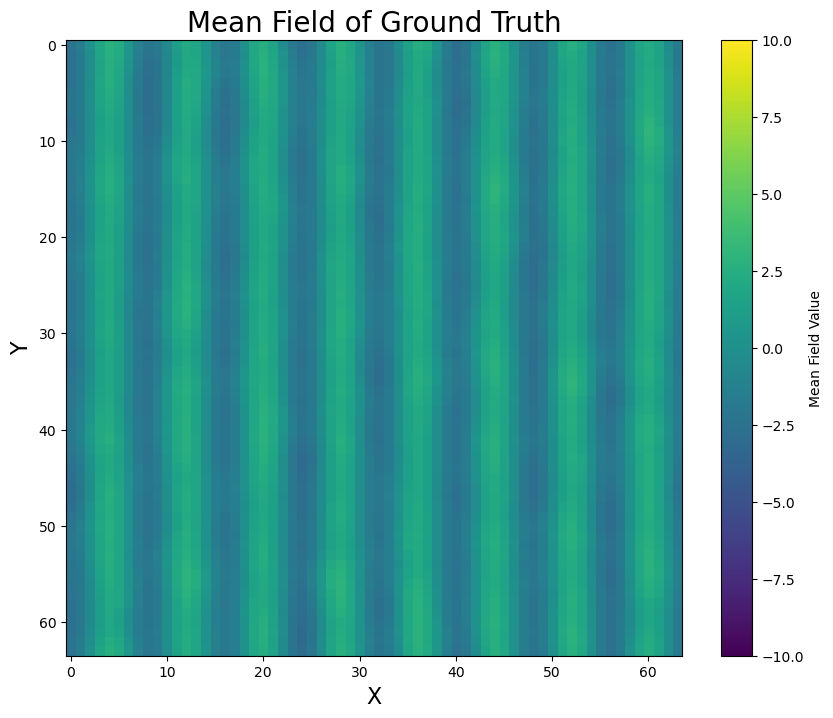

Mean field data saved to '../data/ground_truth_iso_mean_field.npy'


In [37]:
# Create mean field plot
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean field by averaging over all timesteps
mean_field = torch.mean(test_gt, dim=0)

# Plot mean field
plt.figure(figsize=(10, 8))
plt.imshow(mean_field.cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
plt.colorbar(label='Mean Field Value')
plt.title('Mean Field of Ground Truth', fontsize=20)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
# Save the figure
plt.savefig('../ground_truth_kf_mean_field.png', dpi=300, bbox_inches='tight')

plt.show()

# Save the mean field data
mean_field_np = mean_field.cpu().numpy()
np.save('../data/ground_truth_kf_mean_field.npy', mean_field_np)
print("Mean field data saved to '../data/ground_truth_kf_mean_field.npy'")

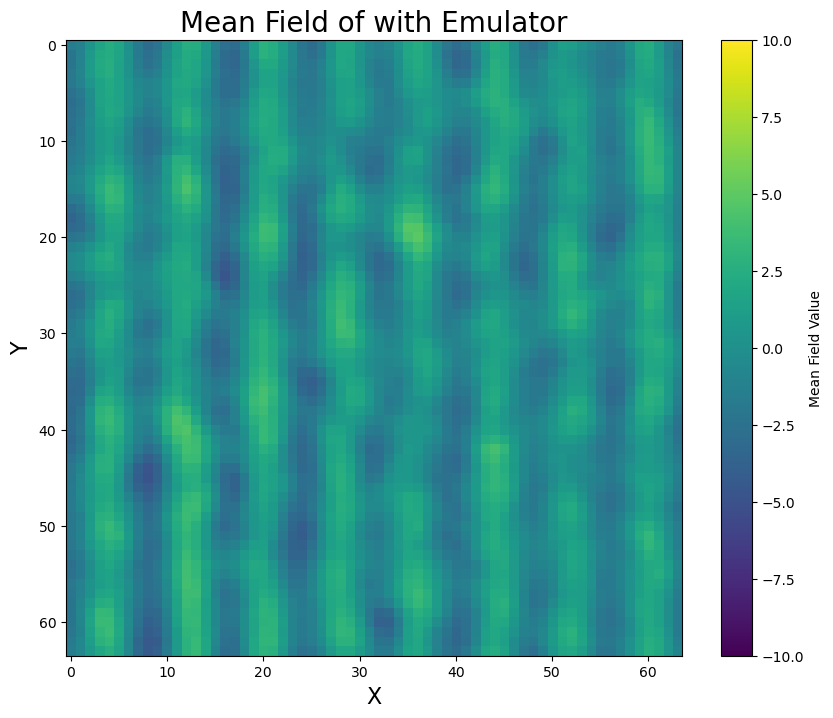

Mean field data saved to '../data/Emulator_iso_mean_field.npy'


In [38]:
# Create mean field plot
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean field by averaging over all timesteps
mean_field = torch.mean(generated_data, dim=0)

# Plot mean field
plt.figure(figsize=(10, 8))
plt.imshow(mean_field.cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
plt.colorbar(label='Mean Field Value')
plt.title('Mean Field of with Emulator', fontsize=20)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
# Save the figure
plt.savefig('../Emulator_kf_mean_field.png', dpi=300, bbox_inches='tight')

plt.show()

# Save the mean field data
mean_field_np = mean_field.cpu().numpy()
np.save('../data/Emulator_kf_mean_field.npy', mean_field_np)
print("Mean field data saved to '../data/Emulator_kf_mean_field.npy'")

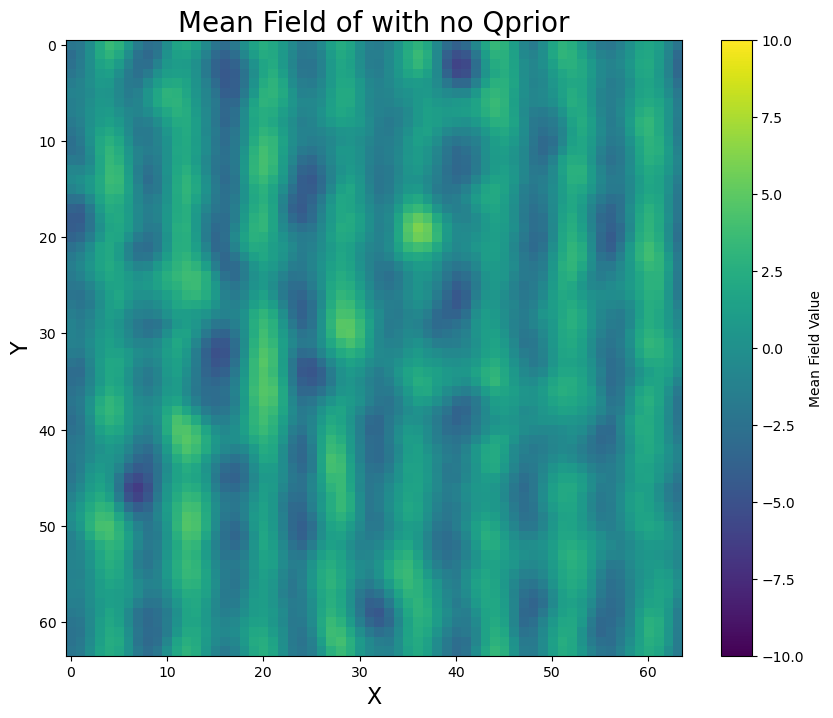

Mean field data saved to '../data/no_qprior_iso_mean_field.npy'


In [8]:
# Create mean field plot
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean field by averaging over all timesteps
mean_field = torch.mean(generated_data, dim=0)

# Plot mean field
plt.figure(figsize=(10, 8))
plt.imshow(mean_field.cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
plt.colorbar(label='Mean Field Value')
plt.title('Mean Field of with no Qprior', fontsize=20)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
# Save the figure
plt.savefig('../no_qprior_iso_mean_field.png', dpi=300, bbox_inches='tight')

plt.show()

# Save the mean field data
mean_field_np = mean_field.cpu().numpy()
np.save('../data/no_qprior_iso_mean_field.npy', mean_field_np)
print("Mean field data saved to '../data/no_qprior_iso_mean_field.npy'")